In [2]:
import numpy as np
import os
from skimage import io, transform
from tqdm import trange, tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as image

In [7]:
files_len = 1
direct = '../img_align_celeba'
files_in = os.listdir(direct)
files = np.random.choice(files_in, files_len)
images = []
for f in tqdm(files):
        images.append(transform.resize(io.imread(direct + '/' + f), (64,64,3), mode='constant'))

100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


In [ ]:
def fc( x, out_size=50, name="fc" , is_output=False, bias_val=0.0):
    shape = x.get_shape().as_list()
    with tf.name_scope(name) as scope:
        W = tf.get_variable("fc_{}_W".format(name), [shape[1], out_size], tf.float32, initializer = tf.contrib.layers.variance_scaling_initializer())
        B = tf.get_variable("fc_{}_B".format(name), [out_size], initializer=tf.constant_initializer(bias_val))
        res = tf.matmul(x, W) + B
        if not is_output:
            res = tf.nn.relu(res)
        return res
    pass

In [ ]:
with tf.Graph().as_default():
    z_len = 100
    batch_size = 64
    
    x = tf.placeholder( tf.float32, [None,64,64,3] )
    z = tf.placeholder(tf.float32, [None,z_len])
    
    c = .0001
    epsilon = .5
    lambd = 10
    with tf.variable_scope("functions"):
        def descriminator_topo(x_func,  num_filt = 2, R=False):
            with tf.variable_scope("descriminator_topo", reuse = R):
                kernel_init = kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
                c0 = tf.layers.conv2d(x_func, 128, 5, 2,  padding = "same", activation = tf.nn.relu,kernel_initializer = kernel_init, name = "d0")
                c1 = tf.layers.conv2d(c0, 256, 5, 2 , padding = "same",activation = tf.nn.relu,kernel_initializer = kernel_init, name = "d1")
                c2 = tf.layers.conv2d(c1, 512, 5, 2 , padding = "same",activation = tf.nn.relu,kernel_initializer = kernel_init, name = "d2")
                c3 = tf.layers.conv2d(c2, 1024, 5, 2 , padding = "same",kernel_initializer = kernel_init,  name = "d3")
                shape = c3.get_shape().as_list()
                c_in = tf.reshape(c3, (-1, shape[1]*shape[2]*shape[3]))
                fc_out = tf.layers.dense(c_in, 1, kernel_initializer = kernel_init, name="fc1_out_d")
            return fc_out
         
        def generator_topo(z_func, num_filt = 3, R = True):
            with tf.variable_scope("generator_topo"): 
                kernel_init = kernel_initializer = tf.contrib.layers.variance_scaling_initializer()
                #fc0 = fc(tf.reshape(z_func, [batch_size,z_len]), out_size = 4*4*1024, name = "fcg")
                fc0 = tf.layers.dense(z_func, 4*4*1024, activation = tf.nn.relu, kernel_initializer = kernel_init, name = "fcg")
                conv_in = tf.reshape(fc0, [-1,4,4,1024])
                c1 = tf.layers.conv2d_transpose(conv_in, 512, 2, 2, activation = tf.nn.relu, kernel_initializer = kernel_init, name = "g1") #[8,8,512]
                c2 = tf.layers.conv2d_transpose(c1, 256, 2, 2, activation = tf.nn.relu, kernel_initializer = kernel_init, name = "g2") #[16,16,256]
                c3 = tf.layers.conv2d_transpose(c2, 128, 2, 2, activation = tf.nn.relu, kernel_initializer = kernel_init, name = "g3") #[64,64,3]
                cout = tf.layers.conv2d_transpose(c3, 3, 2, 2, kernel_initializer = kernel_init, name = "gout")
            return cout
    
    # BEGIN COMPUTATION GRAPH
    with tf.name_scope("generator") as scope:
        twid = generator_topo(z)
        x_twiddle = twid
        
    with tf.name_scope("descriminator") as scope:
        # D for the real image
        d_x = descriminator_topo(x)
        
        # D for the x_twiddle from the generator
        d_x_twiddle = descriminator_topo(x_twiddle, R = True)
        
        # D for the x_hat which is in the line between x and y
        xhat = epsilon * x + (1-epsilon) * x_twiddle
        d_x_hat = descriminator_topo(xhat, R = True)
        
    with tf.name_scope("disc_loss") as scope:
        # Calculate the gradient of x_hat and x_hat's result

        grad = tf.gradients(d_x_hat, [xhat])[0]
        norm = tf.sqrt(tf.reduce_sum(grad**2, axis=[1,2,3]))
        # Expected value = the mean of the values
        des_loss_i = tf.reduce_mean(d_x_twiddle) - tf.reduce_mean(d_x)
        # lambda = arbitrary number they assign to 10, gradient penalty
        des_loss = des_loss_i + lambd * tf.reduce_mean((norm-1)**2)
        
    with tf.name_scope("gen_loss") as scope:
        gen_loss = -tf.reduce_mean(d_x_twiddle)
        
    t_vars = tf.trainable_variables()
    gen_vars = [var for var in t_vars if "generator_topo" in var.name]
    des_vars = [var for var in t_vars if "descriminator_topo" in var.name]
        
    with tf.name_scope("gen_adam") as scope:
        gen_train_step = tf.train.AdamOptimizer(learning_rate=c, beta1=0.0, beta2=0.9).minimize(gen_loss, var_list = gen_vars)
        
    with tf.name_scope("des_adam") as scope:
        des_train_step = tf.train.AdamOptimizer(learning_rate=c, beta1=0.0, beta2=0.9).minimize(des_loss, var_list = des_vars)
        
    init = tf.global_variables_initializer()
    sess = tf.Session()
    writer = tf.summary.FileWriter("./tf_lab7", sess.graph)
    sess.run(init)

    epochs = 10
    descr_iters = 5
    num_z_col = 10


    for ep in tqdm(xrange(epochs)): 
        for ite in xrange(descr_iters):
            real_images = []
            for m in xrange(batch_size):
                ind = np.random.randint(files_len)
                real_images.append(images[ind])
            
            real_images = np.reshape(real_images,(batch_size,64,64,3))
            zs = np.random.rand(batch_size,z_len)
            desc_l, gen_l, des_tr = sess.run([des_loss, gen_loss, des_train_step], feed_dict={x: real_images, z: zs})
        index = np.random.rand(1,z_len)
        gen_tr = sess.run(gen_train_step, feed_dict={x: real_images, z: index})
        if ep%50 == 0:
            print "iteration", ep,": desc loss", desc_l, "gen_l", gen_l
            
    z1 = np.random.rand(z_len)
    z2 = np.random.rand(z_len)
    zspace_rows = []
    for i in xrange(z_len):
        R = np.linspace( z1[i], z2[i], num=num_z_col)
        zspace_rows.append(R)
    zspace =  np.asarray(zspace_rows).T
    print zspace.shape
    
    for i in xrange(num_z_col):
        test_img = sess.run(x_twiddle, feed_dict = {x: real_images, z: np.reshape(zspace[i], (1,z_len))})
        test_out = np.reshape(test_img, [1,64,64,3])
        plt.imshow(test_out[0,:,:,:])
        image.imsave('test_coll_{}.png'.format(i), test_out[0])
    
    for i in xrange(num_z_col):
        ind = np.random.randint(files_len)
        index = np.random.rand(1, z_len)
        gen_tr = sess.run(gen_train_step, feed_dict={x: real_images, z: np.reshape(index, (1,z_len))})
        test_img = sess.run(x_twiddle, feed_dict = {x: real_images, z: np.reshape(index, (1,z_len))})
        test_out = np.reshape(test_img, [1,64,64,3])
        plt.imshow(test_out[0,:,:,:])
        image.imsave('test_img_{}.png'.format(i), test_out[0])
        
    #image.imsave('image_collection.png', collection)
    #img1 = append_images([image64, image128], direction='horizontal')
    #img2 = append_images([image512, image1024], direction='horizontal')
    #final = append_images([img1, img2], direction='vertical')
    #final.save("Fluid_all/00.jpg")
    plt.show()
    sess.close()
writer.close()

In [ ]:
#for less iterations

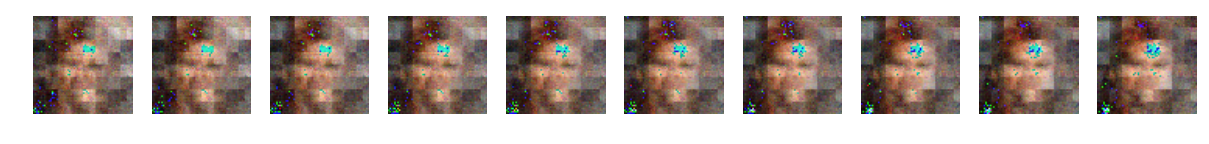

In [41]:
import matplotlib.pyplot as pltt

fig, axes = pltt.subplots(1,10,figsize=(15,15))
for figure in xrange(10):
    fig = pltt.imread('./Lab6/final_images7/test_coll_1_{}.png'.format(figure))
    axes[figure].axis('off')
    axes[figure].imshow(fig)
pltt.show()

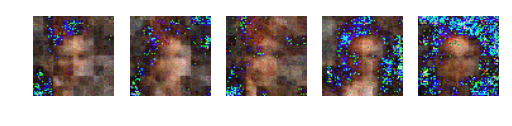

In [34]:
fig, axes = pltt.subplots(1,5)
for figure in xrange(5):
    fig = pltt.imread('./Lab6/final_images7/test_img_1_{}.png'.format(figure))
    axes[figure].axis('off')
    axes[figure].imshow(fig)
pltt.show()

In [ ]:
## More iterations

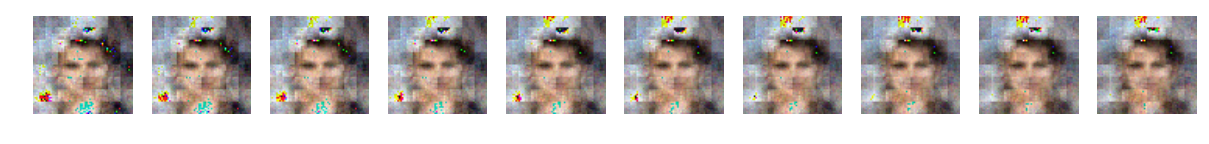

In [40]:
import matplotlib.pyplot as pltt

fig, axes = pltt.subplots(1,10,figsize=(15,15))
for figure in xrange(10):
    fig = pltt.imread('./Lab6/final_images8/test_coll_t_{}.png'.format())
    #axes[figure].figure(figsize=[15,15])
    axes[figure].axis('off')
    axes[figure].imshow(fig)
pltt.show()

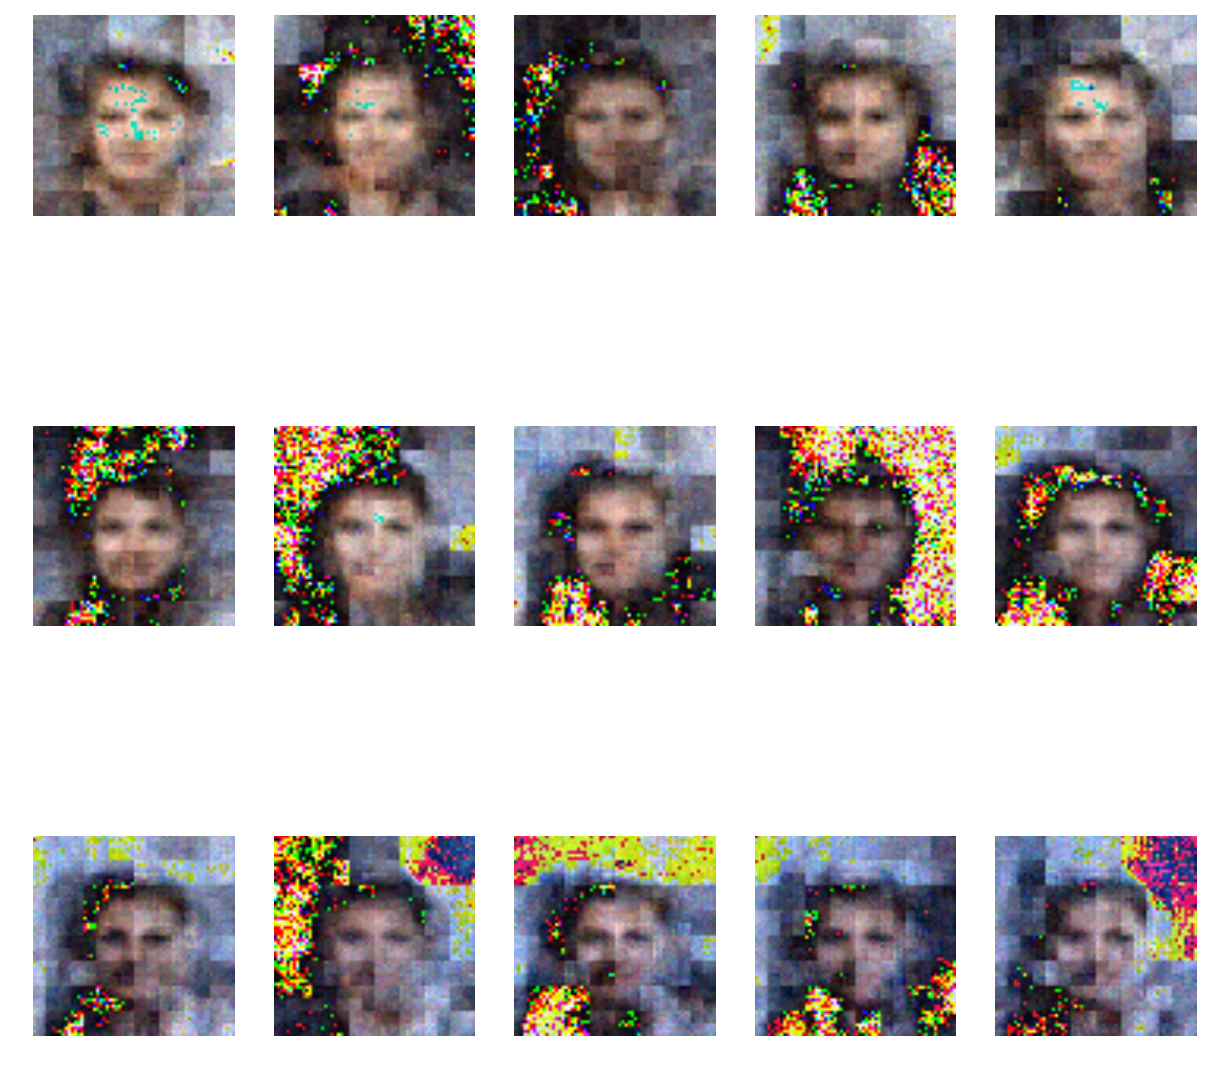

In [47]:
fig, axes = pltt.subplots(3,5, figsize=(15,15))
counter = 0
for row in xrange(3):
    for col in xrange(5):
        fig = pltt.imread('./Lab6/final_images8/test_img_t_{}.png'.format(counter))
        axes[row,col].axis('off')
        axes[row,col].imshow(fig)
        counter += 1
pltt.show()